In [1]:
import csv, math
from math import exp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
    The PID controller from Steil et al 2011, The effect of insulin feedback on closed loop glucose control
    K_P = I_DIR/135. I_DIR: daily insulin requirement (unit/kg). I_DIR = 0.55 * weight(kg)
    T_D is 450 min on day time and 150 min at night.
    T_I is 90 min on daytime and 60 min at night.
    Glucose target is 90 mg/dl (5 mmol/L) on daytime and 110 mg/dl (6.11 mmol/L) at night.
    1 mmol/L = 18 mg/dl.
    The patient is 70kg in this simulation.
    U(t) - mU/min
"""
# G_list is list of G(0), ..., G(t)
def pid_controller(G_list, day_flag):
    # Parameters
    K_P = 0.55*70/135
    if day_flag:
        T_I = 450
        T_D = 90
        G_target = 5
    else:
        T_I = 150
        T_D = 60
        G_target = 6.11
    # Calculate errors between the actual and target glucose levels.
    error_list = G_list - G_target
    
    # Calculate U(t) using PID based on errors
    U_t = K_P * error_list[-1] + (K_P / T_I) * sum(error_list) + (K_P / T_D) * (error_list[-1] - error_list[-2])
    
    if U_t < 0:
        # Remove negative U(t)
        U_t=0
    else:
        # Scale U_t from U/h to mU/min
        U_t = (1000/60) * U_t
    
    return U_t

In [3]:
"""
    Human Glucose - Insulin System Model by Bergman 1981
    A simple 3 equation model.

    States = 
        [Plasma Glucose(G), 
        Plasma Insulin Remote Compartment(X), 
        Plasma Insulin(I)]

    From the paper Furler et al, 1985. Blood Glucose Control by Intermittent Loop Closure in the Basal Mode: 
        Computer Simulation Studies with a Diabetic Model
    
    The patient weighs 70kg.
    G(t) - mmol/L
    X(t) - mU/L
    I(t) - mU/L
    U(t) - mU/min
    D(t) - mmol/L
    V_I = 12L
    n = 0.09 min^-1
    G_b = 4.5 mmol/L
    I_b = 15 mU/L
    X_b = 15 mU/L
    P_1 = -0.028 min^-1
    P_2 = -0.025 min^-1
    P_3 = 0.000005 min^-2 mU^-1 L
"""
def bergman_minmod(x, U, D):
    
    # Get the last G(t), X(t) and I(t)
    G=x[-1, 0]
    X=x[-1, 1]
    I=x[-1, 2]
    
    # Parameters
    G_b = 4.5
    X_b = 15
    I_b = 15
    P_1 = -0.028
    P_2 = -0.025
    P_3 = 0.000005
    V_I = 12
    n = 0.09
    
    # Minimal Model
    Gdt = P_1 * (G - G_b) - (X - X_b) * G + D
    Xdt = P_2 * (X - X_b) + P_3 * (I - I_b)
    Idt = -n * I + U / V_I
    
    dx_dt = [Gdt, Xdt, Idt]
    return dx_dt

In [4]:
def meal_profile(t):
    if t >= 100 and t < 300:
        m = 0.5 * exp(-0.05 * (t-100))
    elif t >= 400 and t < 600:
        m = 1.157 * exp(-0.05 * (t-400))
    elif t >= 700 and t < 900:
        m = 1.816 * exp(-0.05 * (t-700))
    elif t >= 1800 and t < 2000:
        m = 0.6 * exp(-0.05 * (t-1800))
    elif t >= 2100 and t < 2300:
        m = 1.257 * exp(-0.05 * (t-2100))
    elif t >= 2400 and t < 2600:
        m = 1.6 * exp(-0.05 * (t-2400))
    else:
        m = 0
    return m

In [5]:
############ Simulation on the original bergman minimal model ############

In [6]:
tend = 3000
tspan = [i for i in range(tend)]

# Set up initial conditions
x0 = x1 = [4.5, 15, 15]
x = np.array([x0, x1])

# Meal profiles
m = []
for t in tspan:
    m.append(meal_profile(t))

# Simulation
for t in tspan:
    if (t % 1800 <= 900):
        day_flag = True
    else:
        day_flag = False
    
    dx_dt = bergman_minmod(x, pid_controller(x[:, 0], day_flag), m[t])
    
    # x(t) = x(t-1) + dx/dt
    xt = x[-1] + dx_dt
    
    # Append xt to x
    x = np.vstack([x, xt])

# Display the list of G(t), X(t) and I(t)
x

array([[4.50000000e+00, 1.50000000e+01, 1.50000000e+01],
       [4.50000000e+00, 1.50000000e+01, 1.50000000e+01],
       [4.50000000e+00, 1.50000000e+01, 1.36500000e+01],
       ...,
       [5.03368937e+00, 1.49970041e+01, 1.82686864e-11],
       [5.03382669e+00, 1.49970040e+01, 1.66245046e-11],
       [5.03396110e+00, 1.49970039e+01, 1.51282992e-11]])

In [7]:
# Ignore the initial conditions
x = x[2:]
# Select G(t), X(t) and I(t)
G=x[:, 0]
X=x[:, 1]
I=x[:, 2]

# Set the thresholds
glucose_high = 8
glucose_low = 3.9

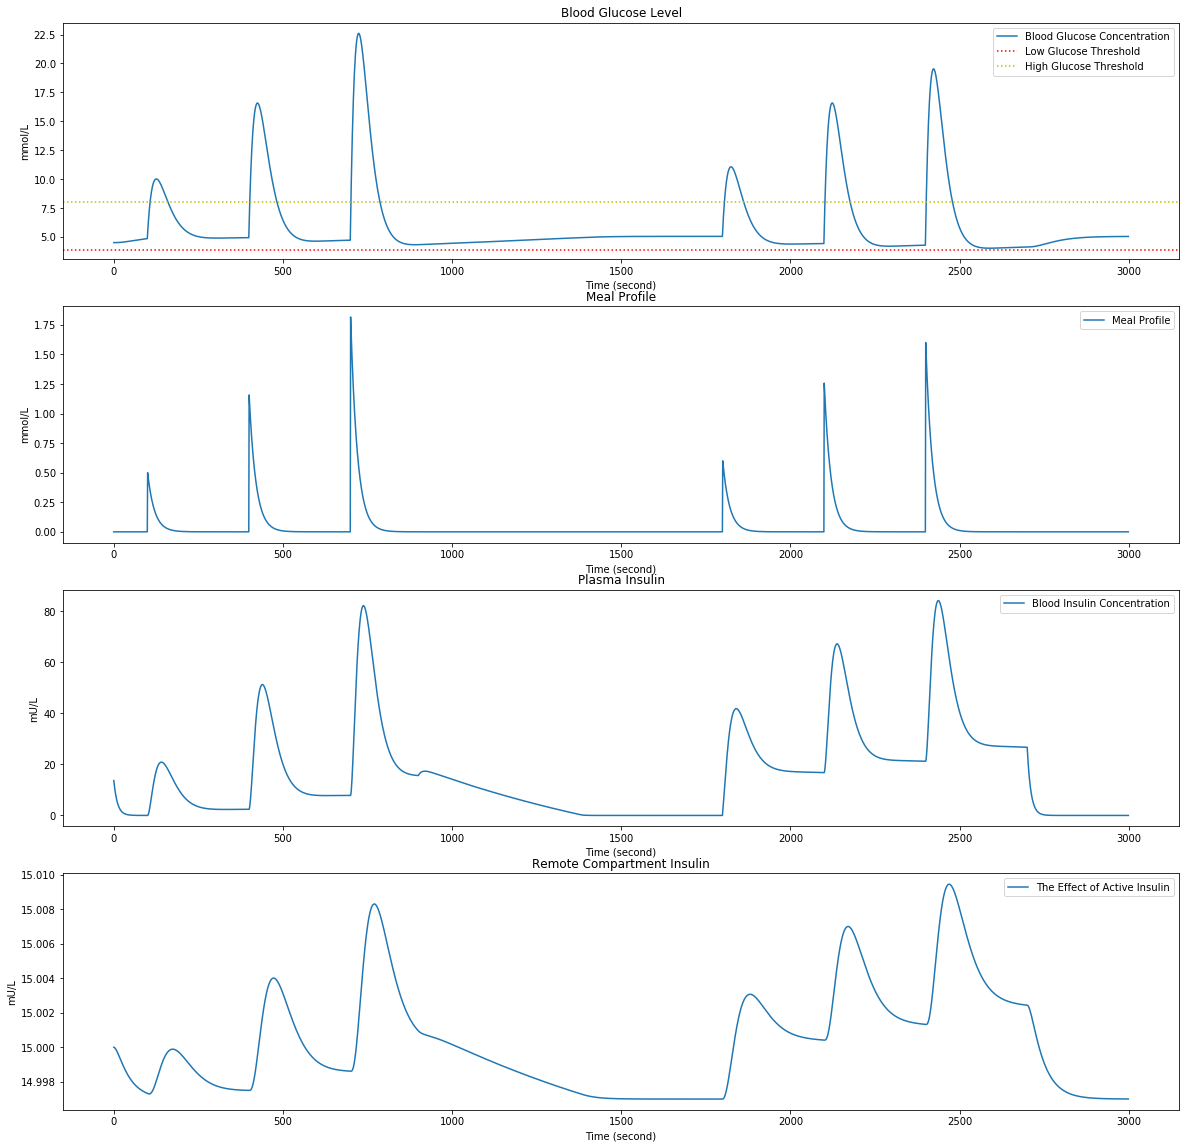

In [8]:
# Visulisation
plt.figure(figsize=(20, 20))
plt.subplot(4,1,1)
plt.plot(tspan,G, label='Blood Glucose Concentration')
plt.axhline(y = glucose_low, color = 'r', linestyle = ':', label='Low Glucose Threshold')
plt.axhline(y = glucose_high, color = 'y', linestyle = ':', label='High Glucose Threshold')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mmol/L')
plt.title('Blood Glucose Level')

plt.subplot(4,1,2)
plt.plot(tspan, m, label='Meal Profile')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mmol/L')
plt.title('Meal Profile')

plt.subplot(4,1,3)
plt.plot(tspan, I, label='Blood Insulin Concentration')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mU/L')
plt.title('Plasma Insulin')

plt.subplot(4,1,4)
plt.plot(tspan, X, label='The Effect of Active Insulin')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mU/L')
plt.title('Remote Compartment Insulin')

plt.show()